# scVelo

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

from natsort import natsorted
from matplotlib import rcParams

random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

rcParams['figure.figsize'] = 7, 7

In [2]:
%run ../scripts/helpers.py

In [3]:
adata_velocity = sc.read("../data/processed/04_scvelo.h5ad")

selected_cells = pd.read_csv("../results/03_subset_cells.csv", index_col=1)
sub = adata_velocity[selected_cells.index, ]

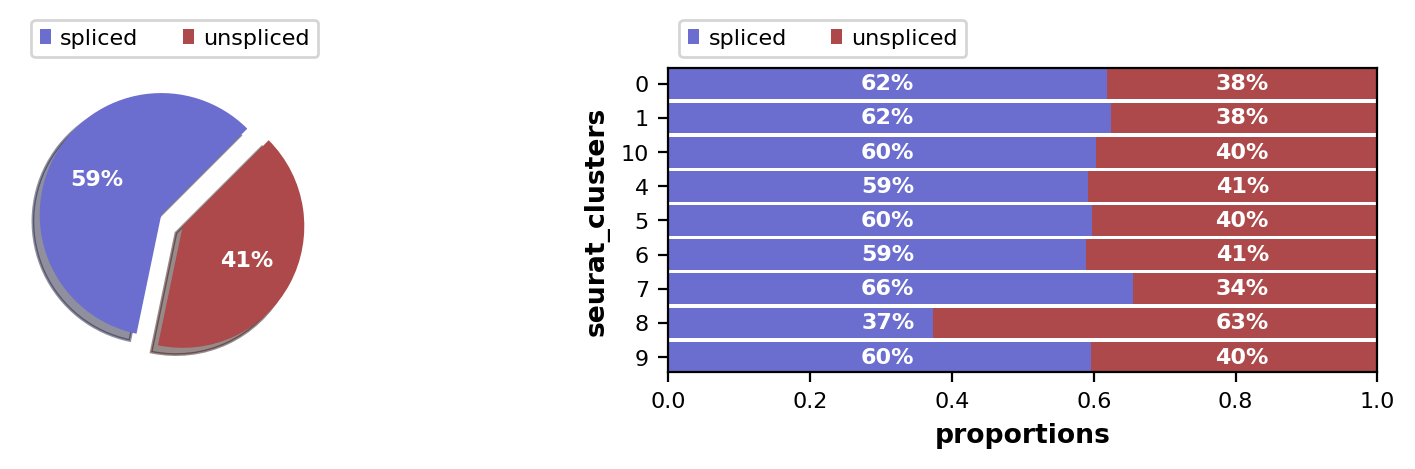

In [4]:
scv.pl.proportions(sub, groupby="seurat_clusters")

In [5]:
sub = run_scvelo(sub)

Trying to set attribute `.obs` of view, copying.


Filtered out 13986 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/224 cores)


  0%|          | 0/1198 [00:00<?, ?gene/s]

    finished (0:00:43) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/224 cores)


  0%|          | 0/1805 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


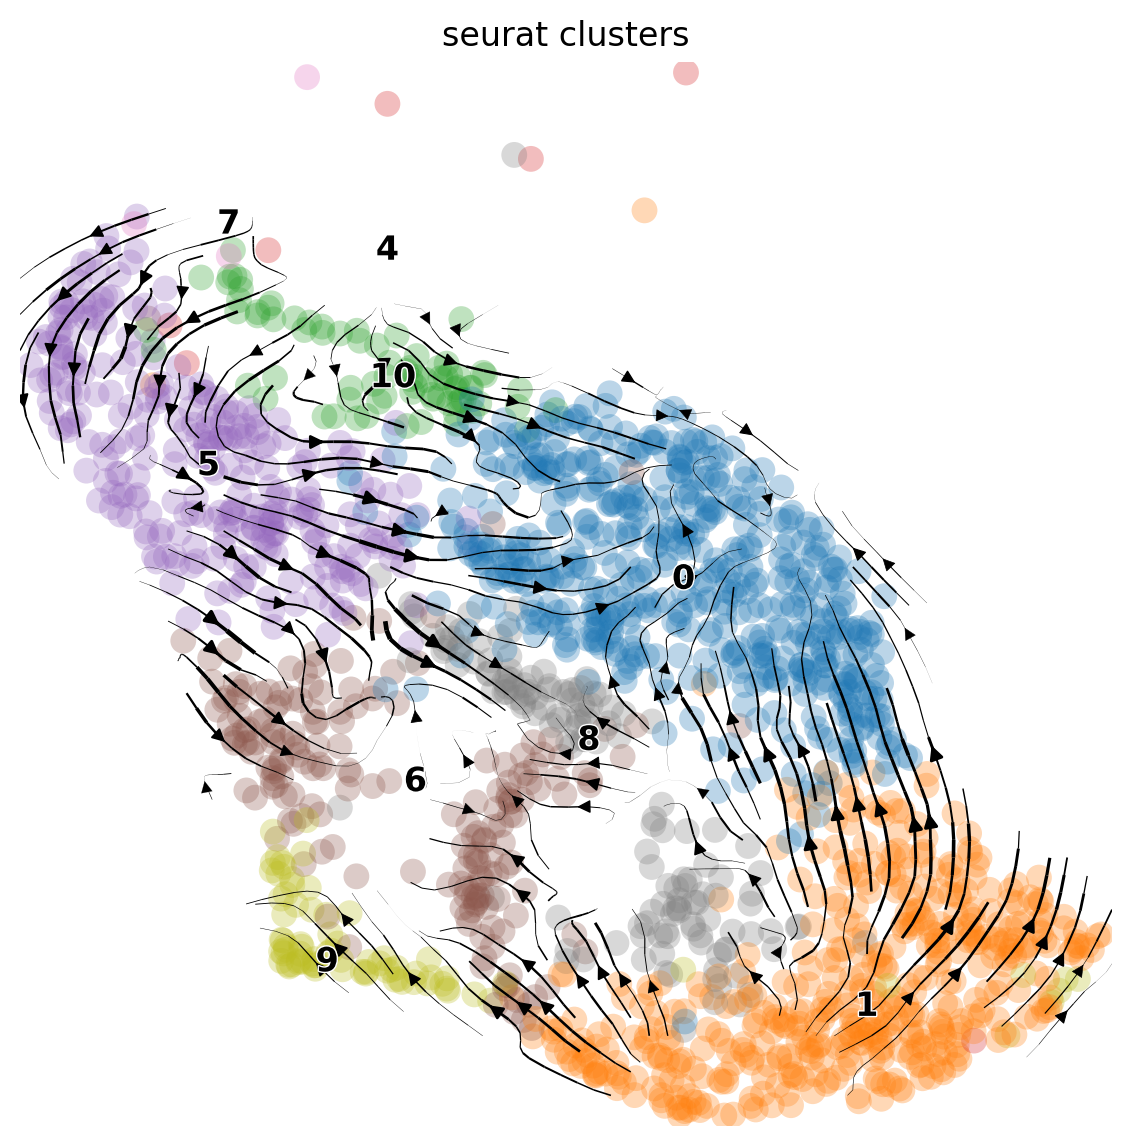

In [6]:
scv.pl.velocity_embedding_stream(sub, basis='umap', color=['seurat_clusters'])

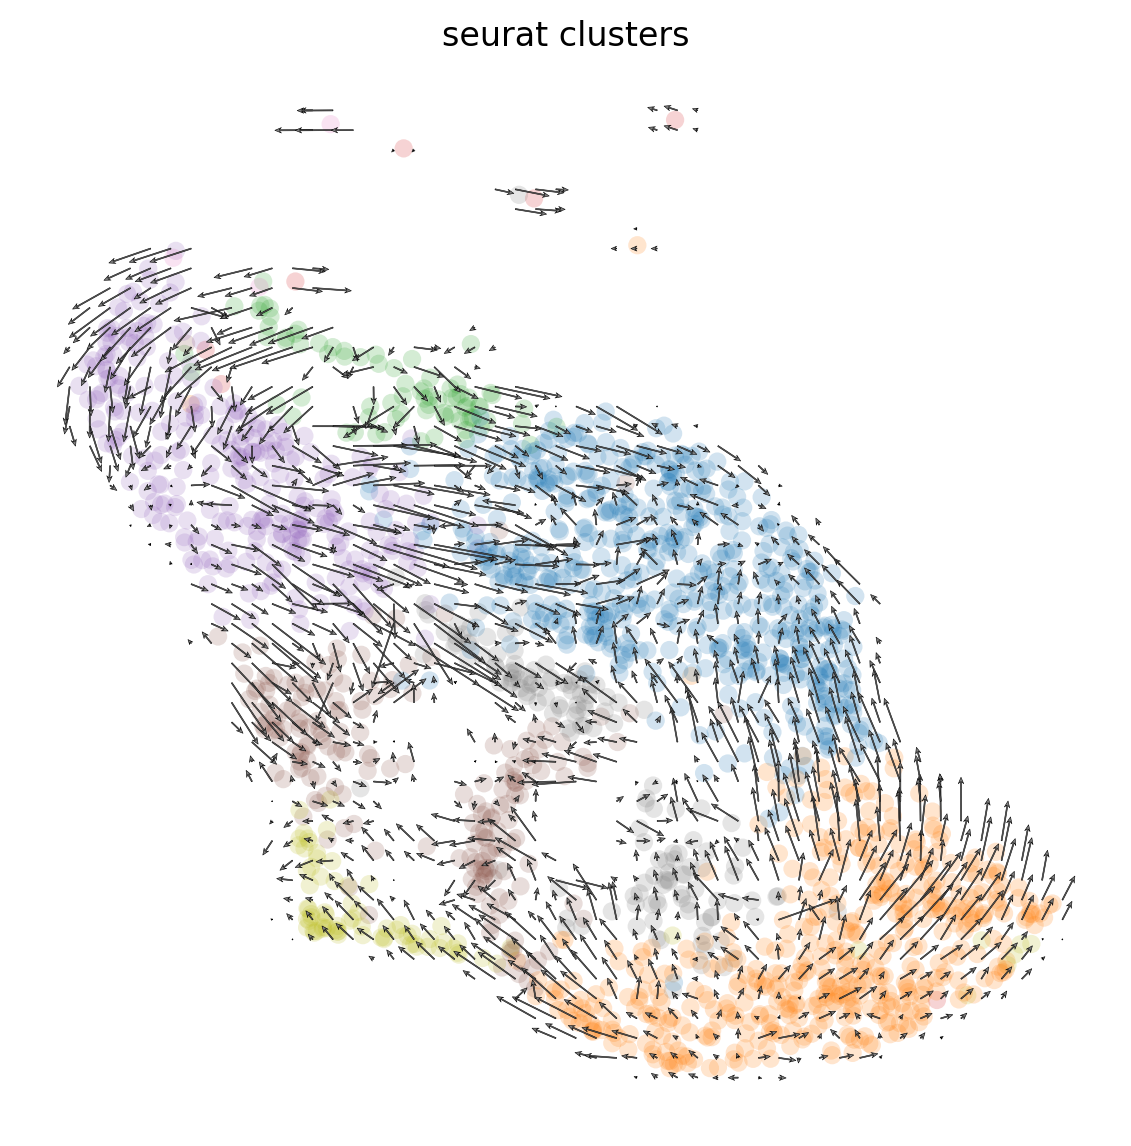

In [7]:
scv.pl.velocity_embedding_grid(sub, basis='umap', color='seurat_clusters', arrow_length=5)

In [8]:
hto = sc.read("../data/processed/02_rna_hto.h5ad")
hto = hto[selected_cells.index, ]

In [9]:
sub.obs['HTO'] = hto.obs['HTO_classification']

... storing 'HTO' as categorical


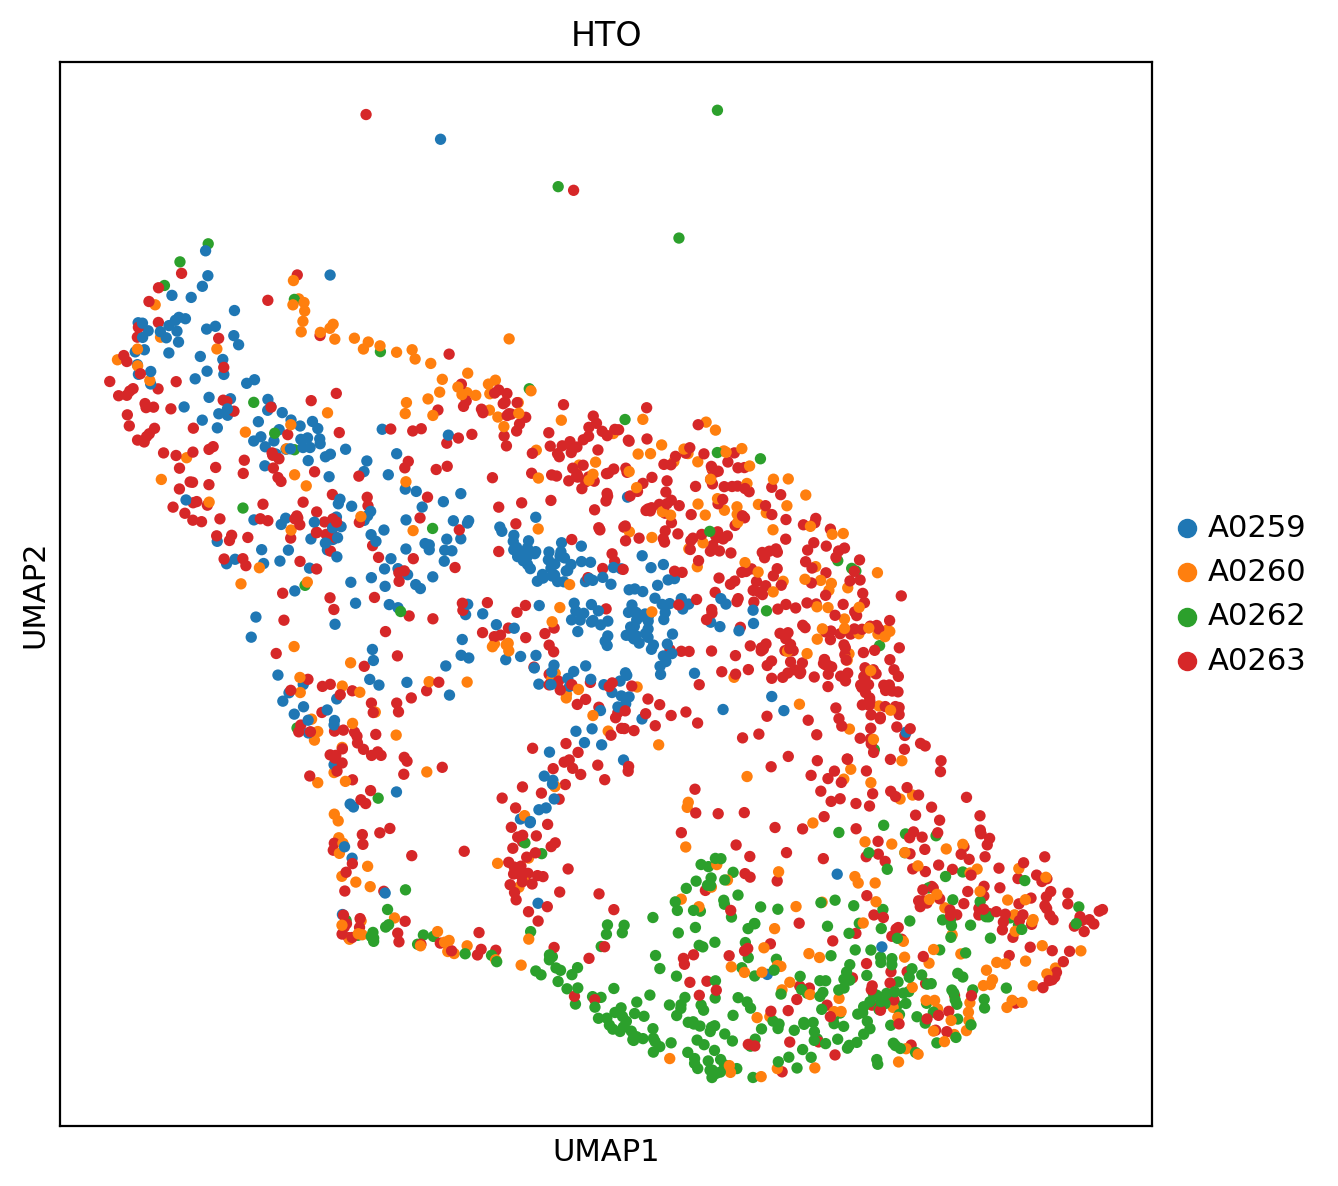

In [10]:
sc.pl.umap(sub, color="HTO")

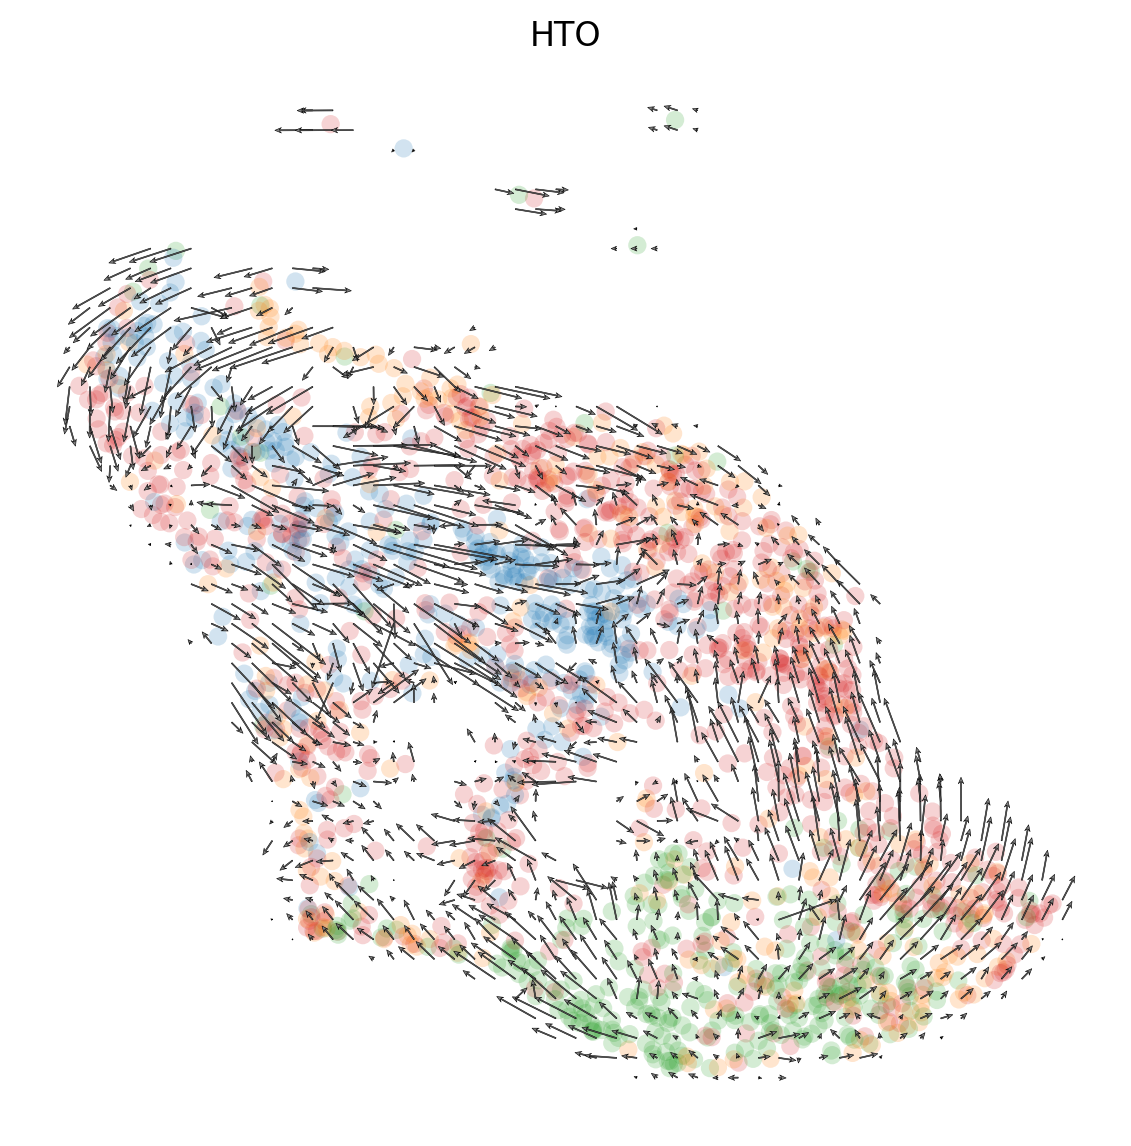

In [11]:
scv.pl.velocity_embedding_grid(sub, basis='umap', color='HTO', arrow_length=5)

## Velocity pseudotime

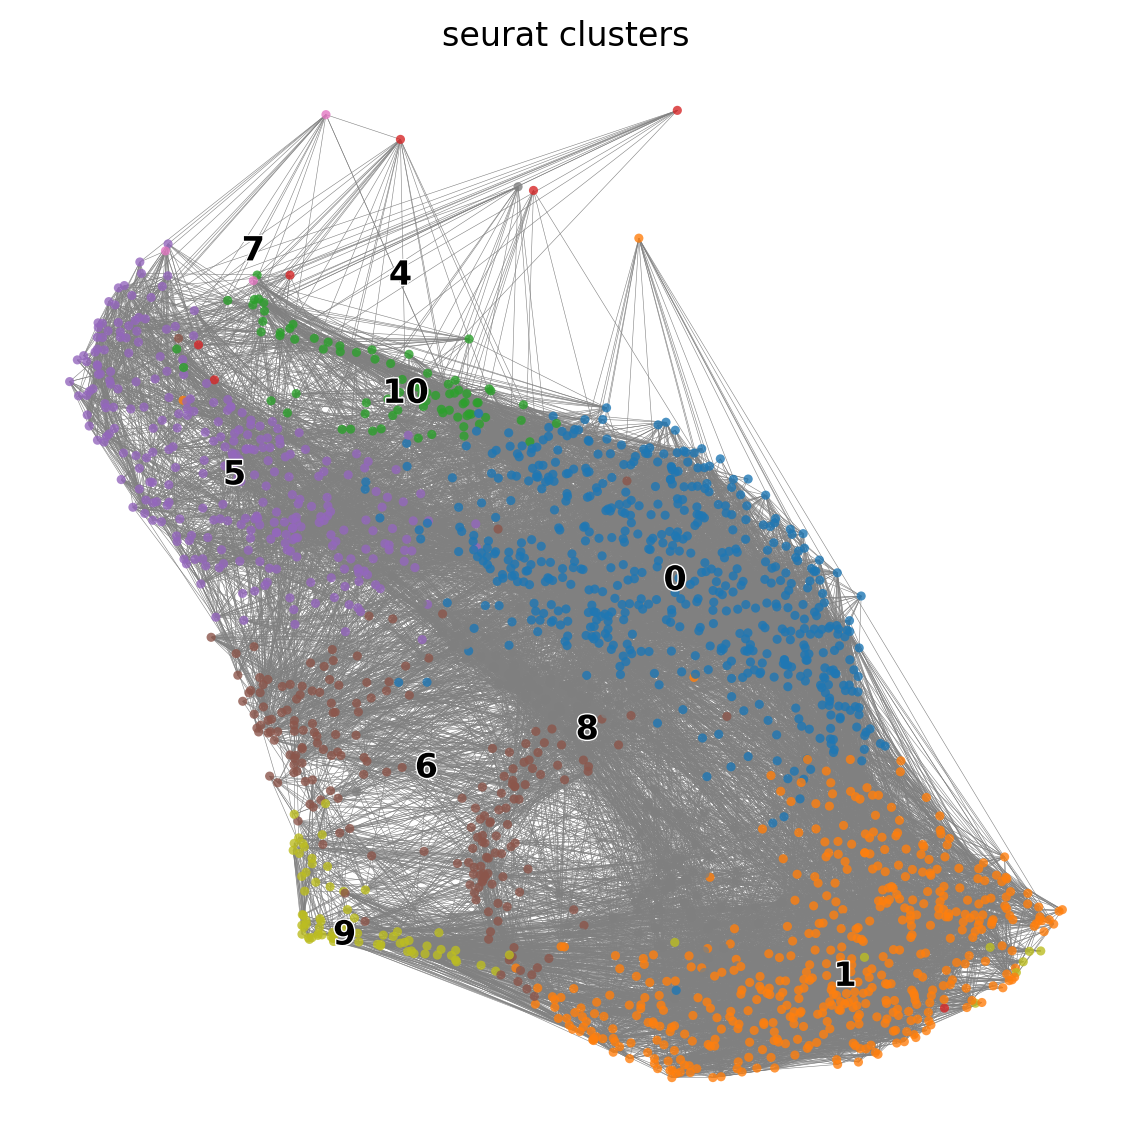

In [12]:
scv.pl.velocity_graph(sub, color='seurat_clusters')

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


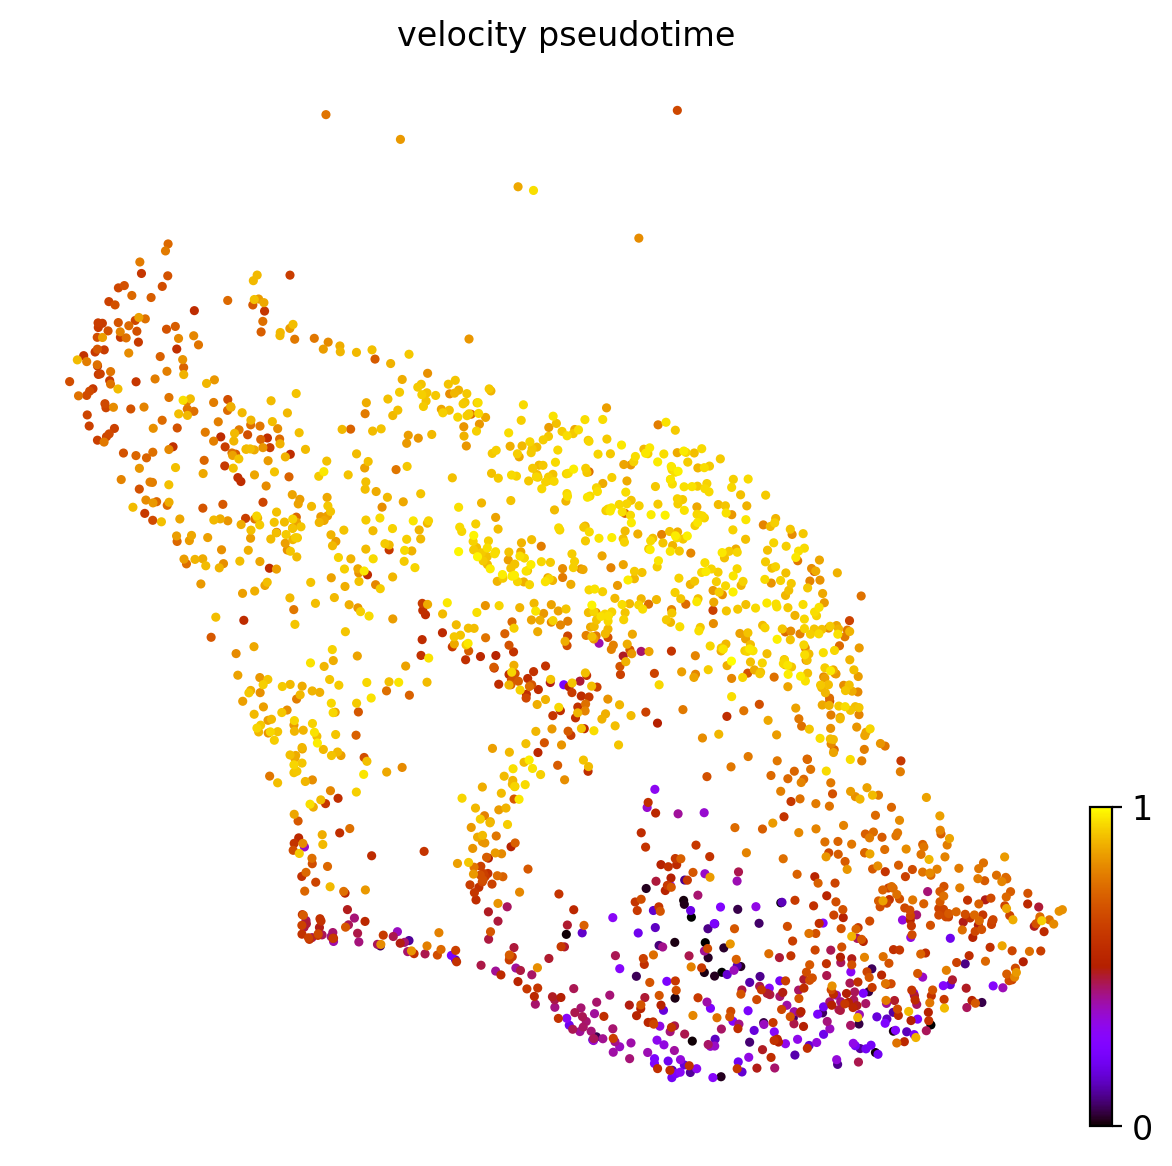

In [13]:
scv.tl.velocity_pseudotime(sub)
scv.pl.scatter(sub, color='velocity_pseudotime', cmap='gnuplot')

## Estimated latent time from modeling

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


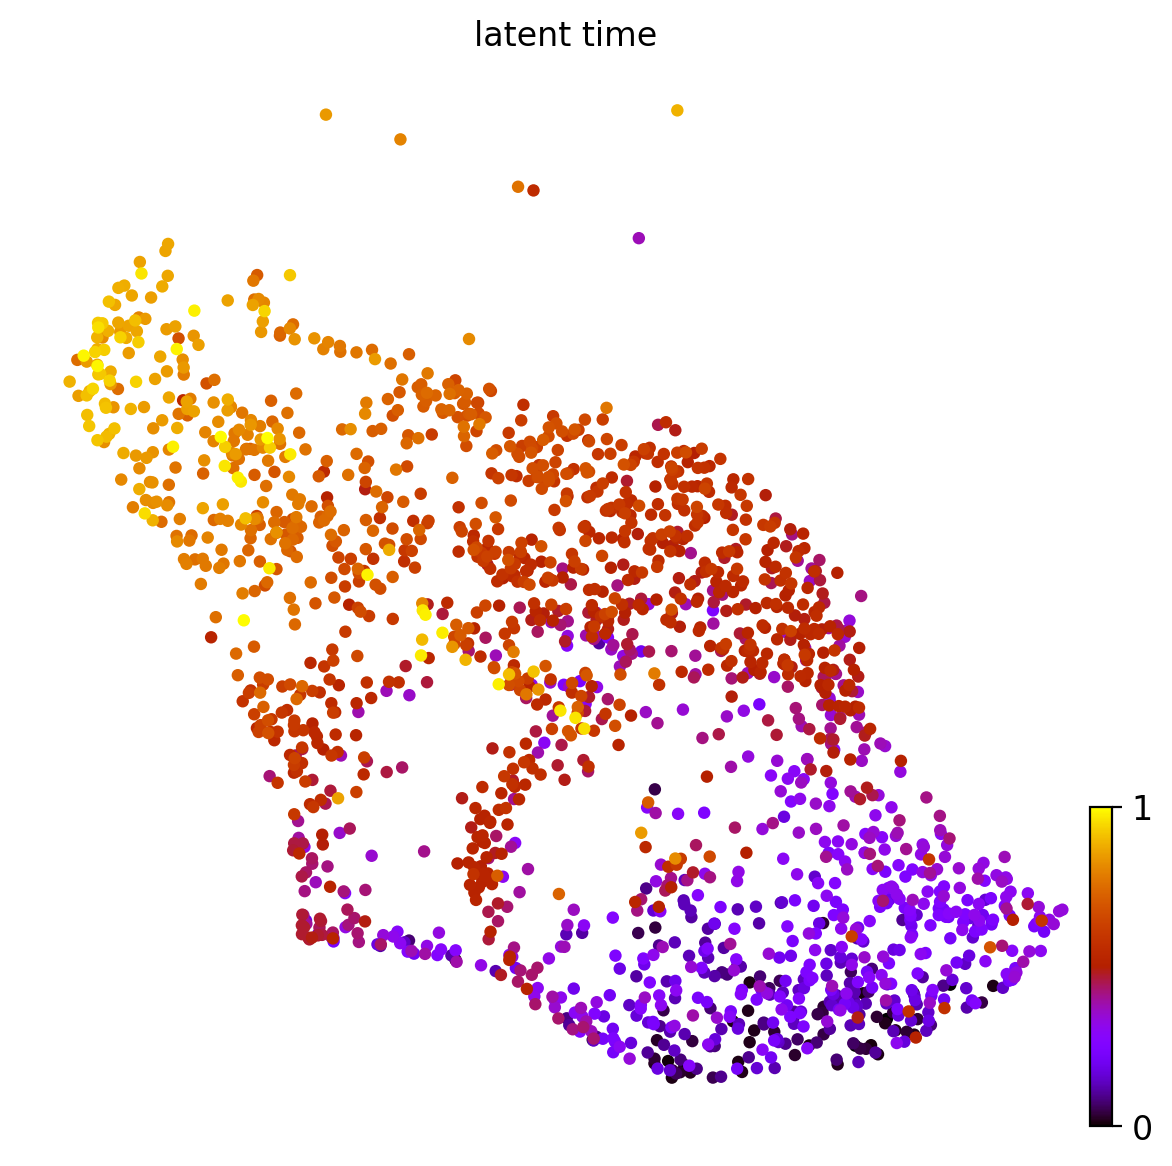

In [14]:
scv.tl.latent_time(sub)
scv.pl.scatter(sub, color='latent_time', color_map='gnuplot', size=80)

Here we can see when we order genes based on latent time what are the most likely driving factors

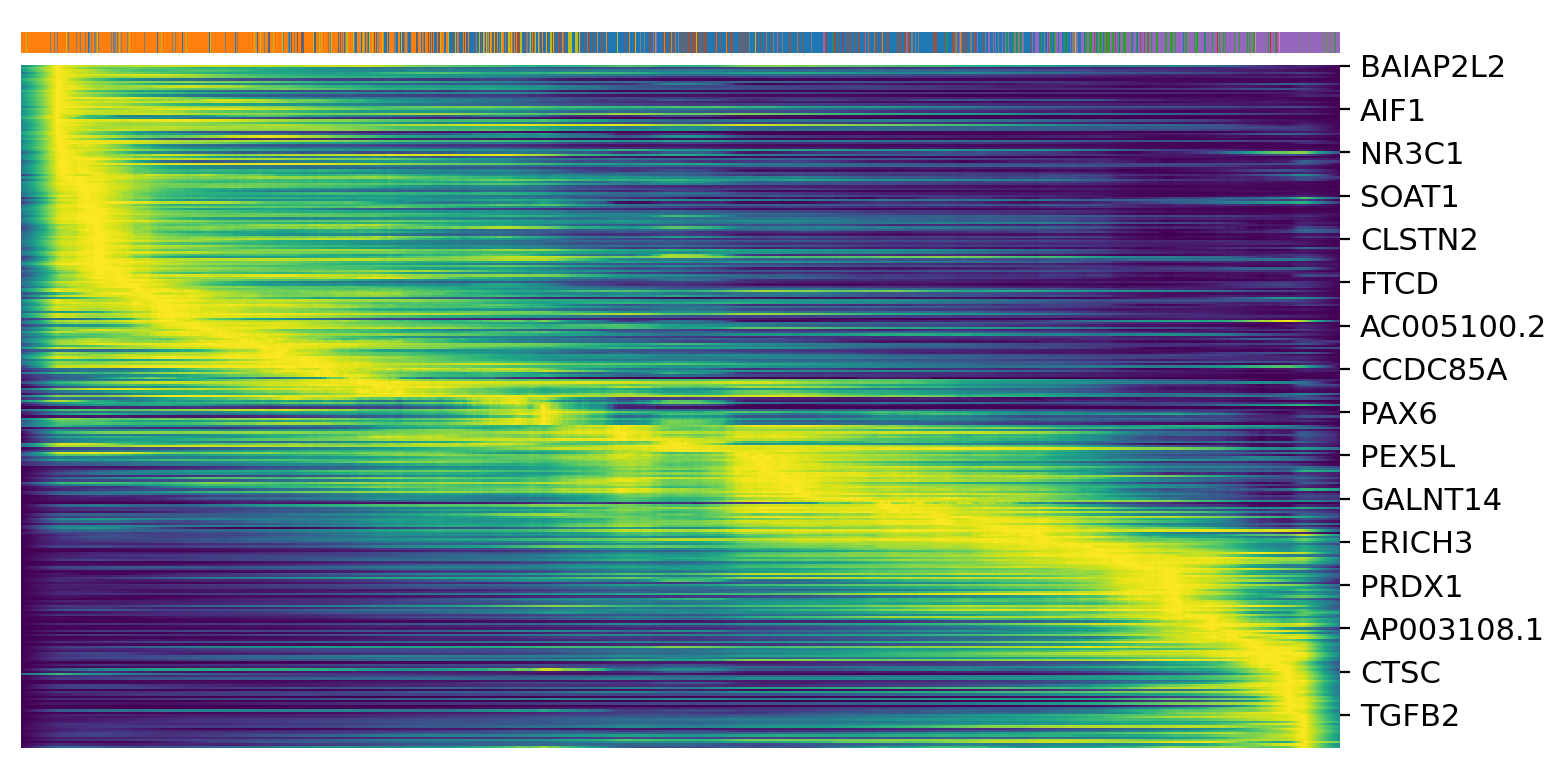

In [15]:
top_genes = sub.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(sub, var_names=top_genes, sortby='latent_time', col_color='seurat_clusters', n_convolve=100)

We can further visualize the ration between spliced and unspliced reads. 
How to read the plot
- dashed line in the center is a "steady-state"
- upper line: upregulation
- lower line: downregulation

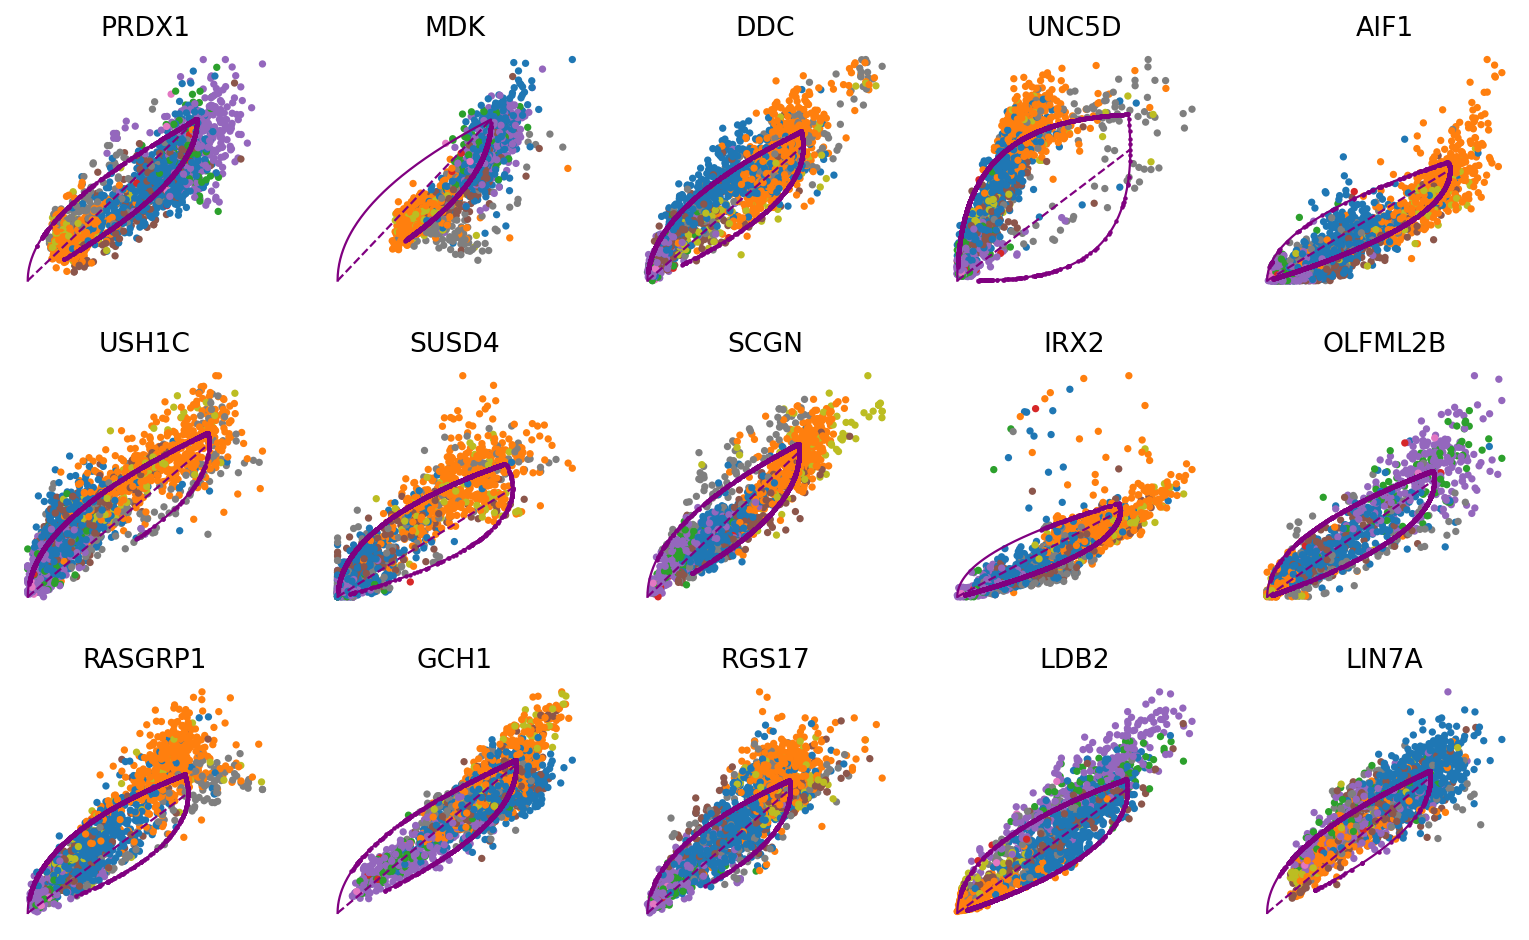

In [16]:
top_genes = sub.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(sub, basis=top_genes[:15], ncols=5, frameon=False, color='seurat_clusters')

Down below is a list of top 20 driving genes based on the modeling

In [17]:
scv.tl.rank_dynamical_genes(sub, groupby='seurat_clusters')
df = scv.get_df(sub, 'rank_dynamical_genes/names')
df.head(20)

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


0        1        10        4        5        6          7  \
0       PRDX1     SCGN      MAP2    USH1C      MDK      MDK       MAP2   
1         DDC    NRXN1   FAM107B  RASGRP1     MAP2    PRDX1     GABBR2   
2       GFRA1    UNC5D     PRDX1    PRDX1  FAM107B    USH1C    FAM107B   
3         MDK      MDK       MDK     AIF1      PAM     SCGN      GFRA1   
4       UNC5D      FEV     LIN7A    NRXN1    S100Z     AIF1      TLCD4   
5       NRXN1    FGF14      DLL1     SCGN  HTATSF1   SPOCK1       RGS4   
6   LINC01088      DDC   TMEM108     GRM8    PRDM8      FOS      TGFB2   
7       USH1C   OR51E1      LDB2   SNHG18    LIN7A    SUSD4      PRDM8   
8        GCH1    USH1C       PAM      NES     TDO2      DDC    COL16A1   
9      ANTXR2    CELF4      RGS4   TRMT9B    CELF4   HMGCS1  LINC01088   
10       LDB2     GRM8     TGFB2     DLL1    NDST3    GFRA1      GRID1   
11     TRMT9B    SUSD4     TLCD4    PEX5L     THRB    ACTG1      CADM2   
12      RGS17    GRIK2     CELF4    S100Z     ELK3    H2AFJ    HSPA12A   
13       SCGN     RCN2     GFRA1    SGPL1     DSEL   GABBR2      MTSS1   
14        PAM   ACVR1C     ITGB8     MAP2    ACTG1    RGS17      ITGB8   
15     GABBR2  ADAMTS5    GABBR2   PCDH17     GCH1   TMEM37        NES   
16      LIN7A    PEX5L  BAIAP2L2     TDO2     GCLM     LDB2    TMEM108   
17     PLCXD3   SPOCK1   HTATSF1     MMUT    TLCD4  OLFML2B      S100Z   
18      TGFB2    LIN7A      GCLM   IGFBP5   KLHL35   ANTXR2      LSAMP   
19    RASGRP1  HTATSF1     ROBO2    CADM2    PRDX1    TGFB2       SYT4   

              8         9  
0        ANTXR2      AIF1  
1         H2AFJ       MDK  
2          LDB2     USH1C  
3          GCH1     ESRRG  
4          RGS4     SUSD4  
5         ESRRG     S100Z  
6         GFRA1     ACTG1  
7       OLFML2B     TLCD4  
8         PRDX1     RGS17  
9           AK5      AMPH  
10  PALM2-AKAP2      TDO2  
11        ACTG1    HMGCS1  
12        LIN7A      RGS4  
13       ACVR1C  TNFRSF21  
14         SCGN      MAP2  
15         TDO2     KIF19  
16       IGFBP5     H2AFJ  
17         MAP2      GRM8  
18      COL16A1   RASGRP1  
19        SUSD4     UNC5D

## Trajectory inference using paga from velocities

In [18]:
sub.uns['neighbors']['distances'] = sub.obsp['distances']
sub.uns['neighbors']['connectivities'] = sub.obsp['connectivities']

scv.tl.paga(sub, groups='seurat_clusters')
df = scv.get_df(sub, 'paga/transitions_confidence', precision=2, index=sub.obs.seurat_clusters.cat.categories, columns=sub.obs.seurat_clusters.cat.categories).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [19]:
df = scv.get_df(sub, 'paga/connectivities_tree', precision=2, index=sub.obs.seurat_clusters.cat.categories, columns=sub.obs.seurat_clusters.cat.categories).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

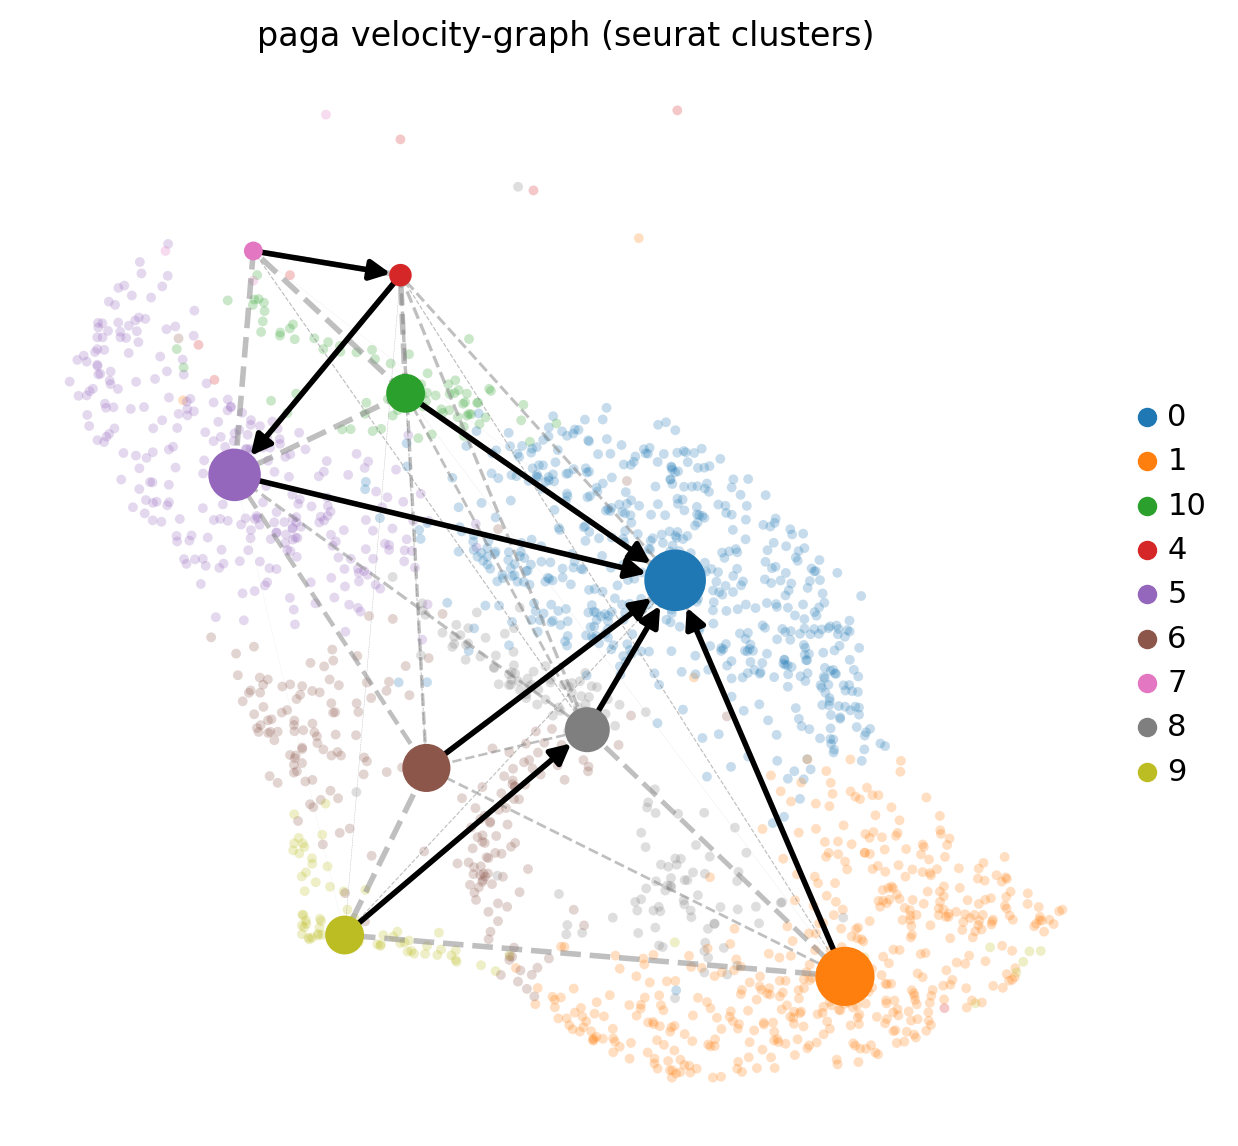

In [20]:
scv.pl.paga(sub, basis='umap', size=50, alpha=.25, min_edge_width=2, node_size_scale=1.5)

We can apply filtering on the infered trajectory inference if some parts don't make sense. Down below I display final trajectory where we expect at least 60% confidence.

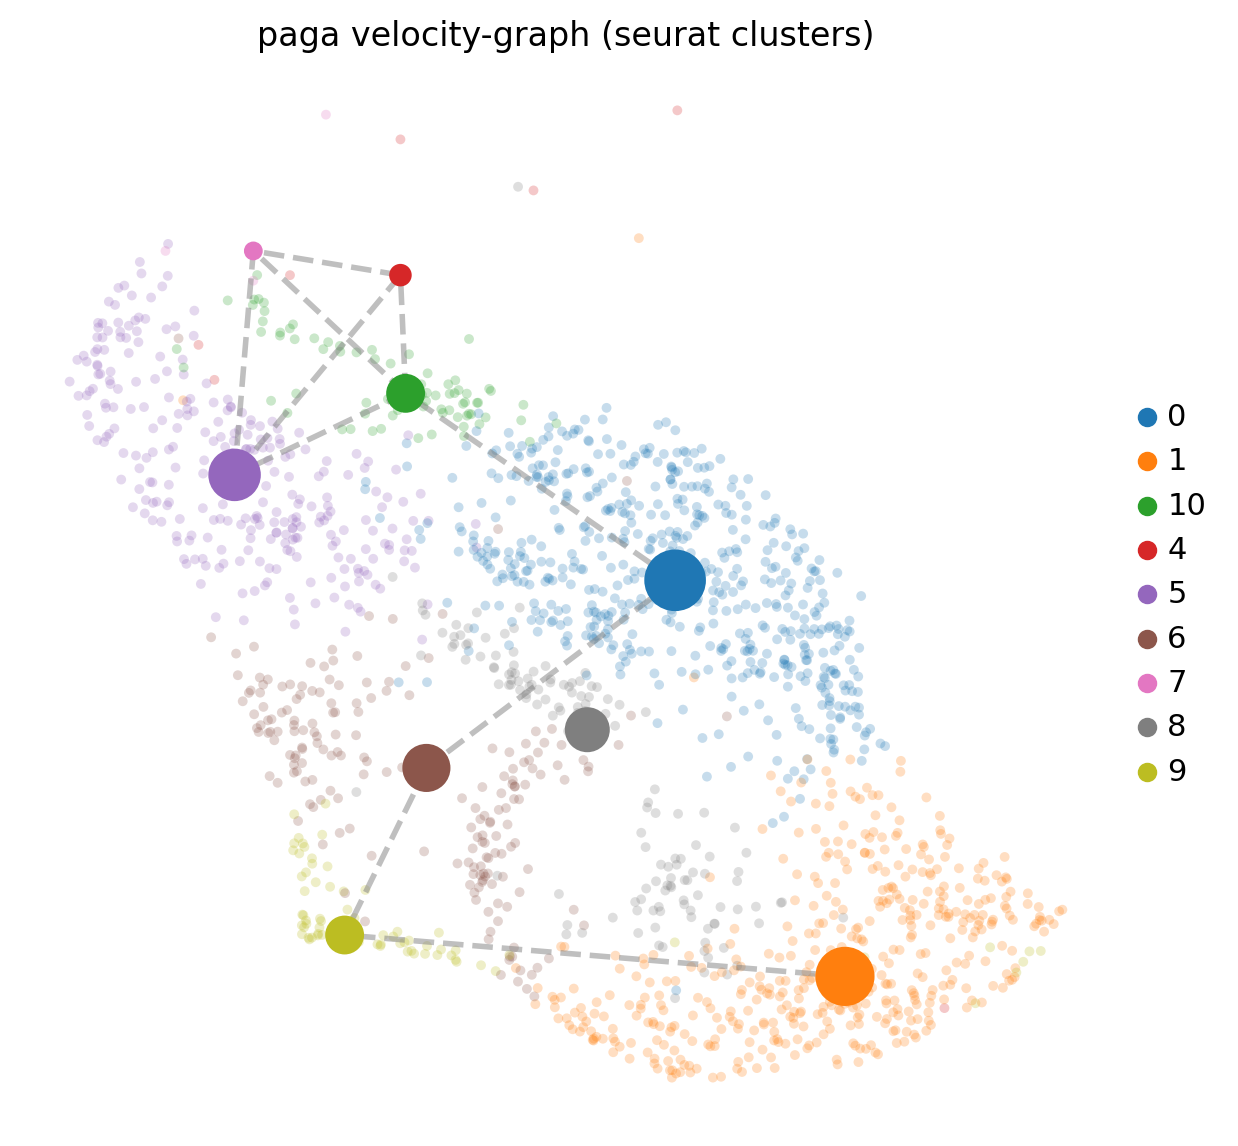

In [21]:
scv.pl.paga(sub, basis='umap', size=50, alpha=.25, min_edge_width=2, node_size_scale=1.5, threshold=0.6)

Two more useful stats: - The speed or rate of differentiation is given by the length of the velocity vector. - The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


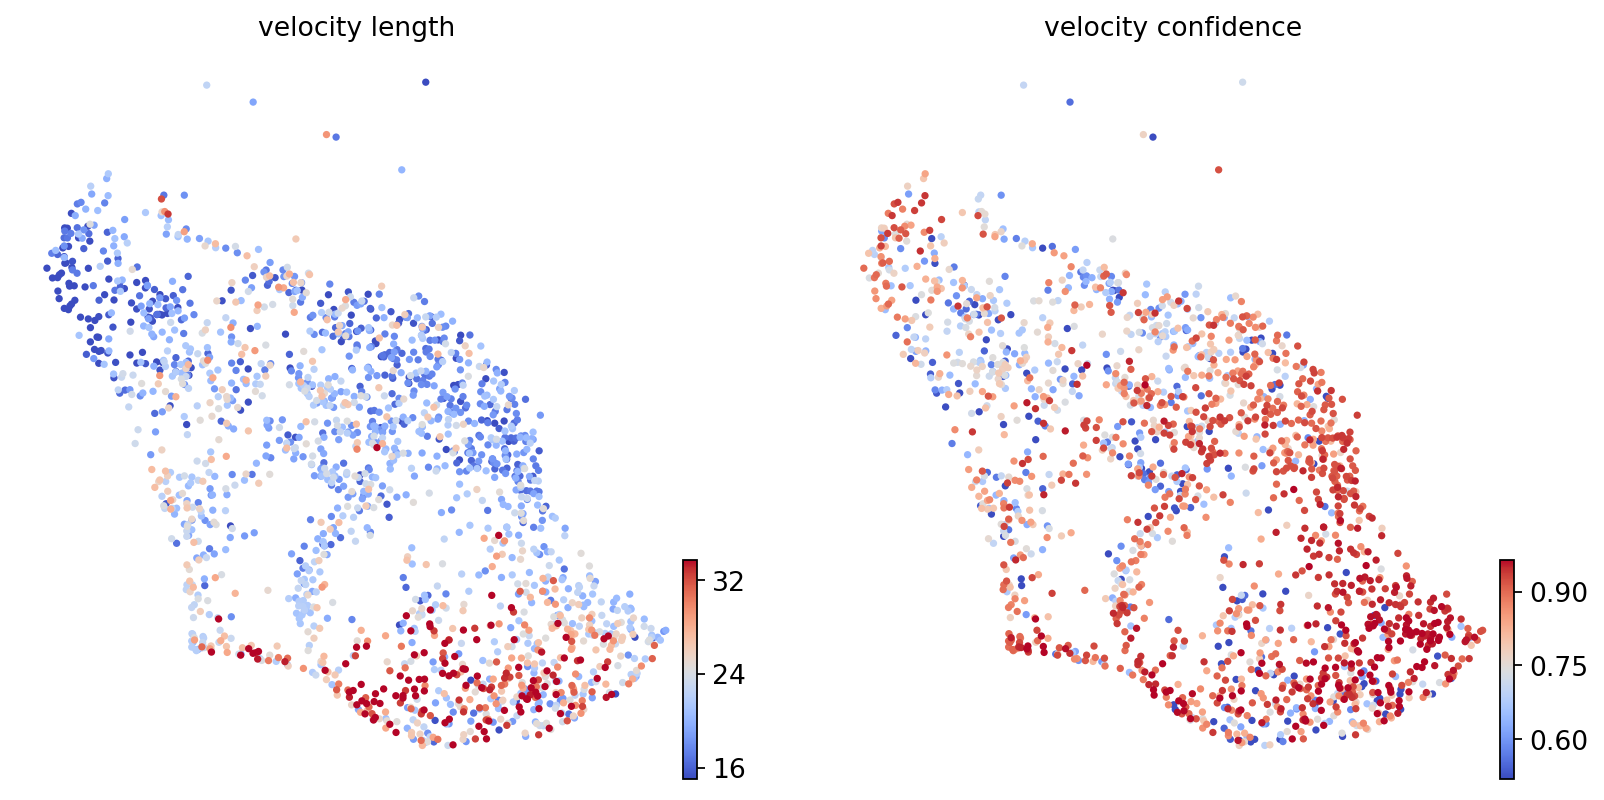

In [22]:
scv.tl.velocity_confidence(sub)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(sub, c=keys, cmap='coolwarm', perc=[5, 95])

In [23]:
df = sub.obs.groupby('seurat_clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

## DLK1

Seems like DLK1 is mostly stable gene

In [24]:
rcParams['figure.figsize'] = [4, 4]

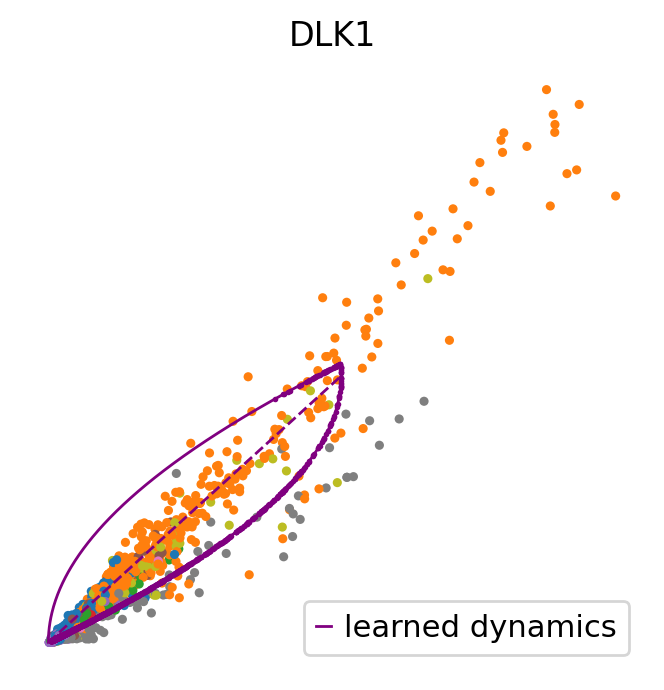

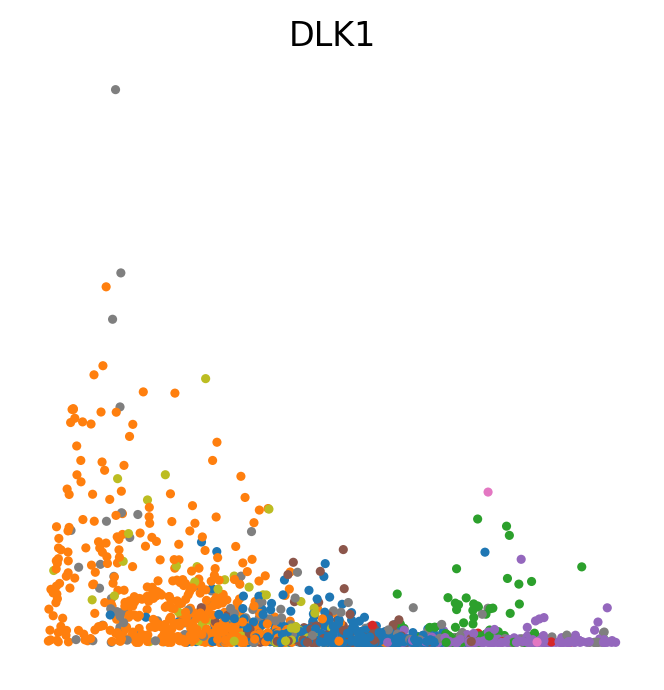

In [25]:
var_names = ['DLK1']
scv.pl.scatter(sub, var_names, frameon=False, color='seurat_clusters')
scv.pl.scatter(sub, x='latent_time', y=var_names, frameon=False, color='seurat_clusters')

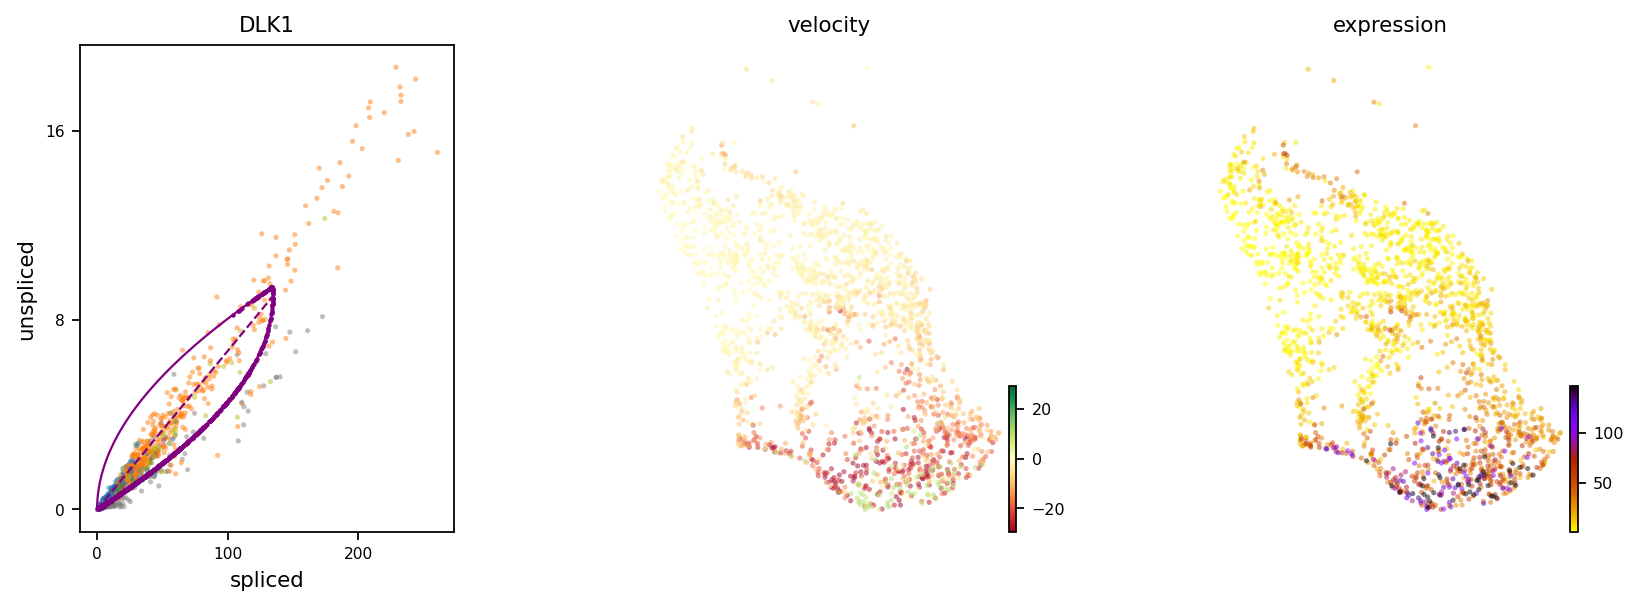

In [26]:
rcParams['figure.figsize'] = [8, 8]
scv.pl.velocity(sub, var_names, color="seurat_clusters")

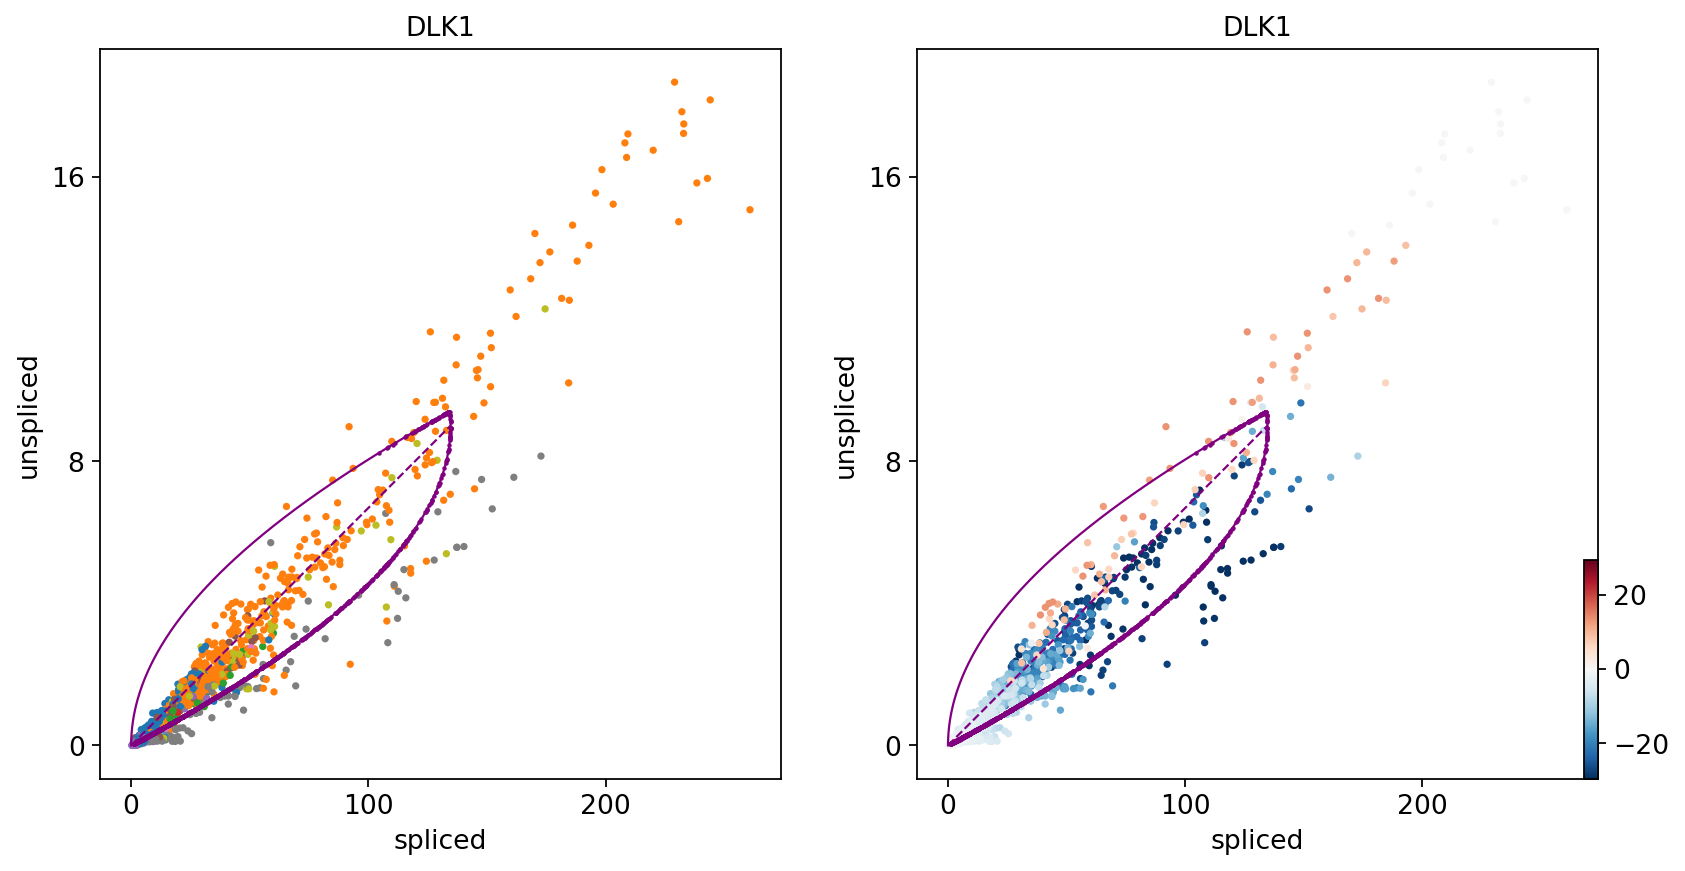

In [27]:
scv.pl.scatter(sub, var_names, color=['seurat_clusters', 'velocity'])

## Save notebook

In [28]:
!jupyter nbconvert --to html 04_scvelo_subset.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 04_scvelo_subset.ipynb to html
[NbConvertApp] Writing 703505 bytes to ../reports/04_scvelo_subset.html
